## Kaggle DIJA 30 Stock Time Series with LSTM

In [1]:
import os
import copy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras import Sequential,layers

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
data_dir_path = os.path.join(os.getcwd(),"data")

#### Extracting Desired File

In [4]:
def extract_file(file_save_path,file_name='all'):
    list_of_files = os.listdir(file_save_path)
    
    file_path_list =[]
    
    for file in list_of_files:
        file_name_temp=file.split("_")
        if file_name_temp[0].lower()==file_name.lower():
            file_path_list.append(file)
            

    return file_path_list

In [5]:
files = extract_file(data_dir_path,file_name='AAPL')

In [6]:
files

['AAPL_2006-01-01_to_2018-01-01.csv']

In [7]:
df_init = pd.read_csv(os.path.join(data_dir_path,files[0]))

In [8]:
df_init.head()

,Date,Open,High,Low,Close,Volume,Name
0,2006-01-03,10.34,10.68,10.32,10.68,201853036,AAPL
1,2006-01-04,10.73,10.85,10.64,10.71,155225609,AAPL
2,2006-01-05,10.69,10.70,10.54,10.63,112396081,AAPL
3,2006-01-06,10.75,10.96,10.65,10.90,176139334,AAPL
4,2006-01-09,10.96,11.03,10.82,10.86,168861224,AAPL


In [9]:
# This method converts the date column to date time object, and set the Date as the index of the data frame.
def to_timesr(df_wrk,dt_column, dt_format=None):
    
    df=copy.deepcopy(df_wrk) # creating a deep copy of the data, so that the initial dataframe can be kept intact.
    
    if dt_format is None:
        df[dt_column]=pd.to_datetime(df[dt_column],infer_datetime_format=True)
    else:       
        df[dt_column]=pd.to_datetime(df[dt_column],format=dt_format)
        
    
    df.set_index(dt_column,inplace=True)
    return df
    
        
    

In [10]:
#Executing the above method
df_wrk = to_timesr(df_init,"Date",dt_format=None)
df_wrk.head()

,Open,High,Low,Close,Volume,Name
Date,,,,,,
2006-01-03,10.34,10.68,10.32,10.68,201853036,AAPL
2006-01-04,10.73,10.85,10.64,10.71,155225609,AAPL
2006-01-05,10.69,10.70,10.54,10.63,112396081,AAPL
2006-01-06,10.75,10.96,10.65,10.90,176139334,AAPL
2006-01-09,10.96,11.03,10.82,10.86,168861224,AAPL


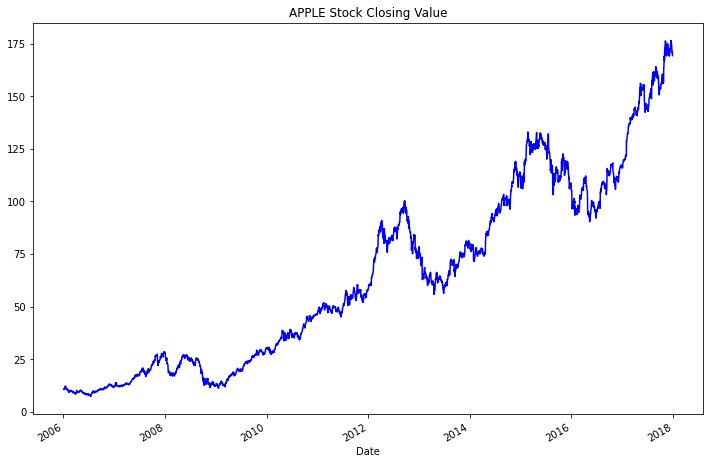

In [11]:
#Method Visualizing the closing value of the stocks for Apple
def plot_stk(df,column,title=None):
    df[column].plot(kind="line",color='b',figsize=(12,8))
    plt.title(title)
    plt.show()
    
plot_stk(df_wrk,'Close',title="APPLE Stock Closing Value")

In [12]:
def data_scaling(data):
    ''' This method takes series or dataframe as input and scales the data using MinMaxScaler'''
    # Initializing the scalar instant
    scaler = MinMaxScaler()
    scaler.fit(data)
    return scaler

In [13]:
def train_data_prep(data, time_step,scaler = None,val_split=None):
    '''
    This method aims to scale the data prepare the train data with the help of another method - data_prep_tm_sr(data, time_step); 
    
    Input:
    data : dataframe or series-like
    time_step: no. of obeservations to be fed or the view window
    Scaler : instance of MinMaxScaler() which will be used for scaling data - Calculated from the module - data_scaling(data):
    val_split : no.of observation to be kept aside for testing purpose - it can be provided as fraction or as integer
    
    Output:
    x_train_data, y_train_data : training dataset pair
    val_data_nos : no.of observation in testing data (it is calculated value when val_split is given as fraction)
    
    '''    
    #Generation of the index no. upto which training set will be considered
    if val_split:
        if isinstance(val_split,int): #when val split is integer
            val_data_nos=val_split
            train_idx_lim=data.shape[0]-val_split
            #Preparation of training:
            if scaler:
                data_temp=data[:train_idx_lim]
                data_scaled= scaler.transform(data_temp) # only training data is scaled.
            
        
        else:
            train_idx_lim=int(data.shape[0]*(1-val_split)) #when val_split is fraction
            val_data_nos=data.shape[0]-train_idx_lim
        
            #Preparation of training:
            if scaler:
                data_temp=data[0:train_idx_lim]
                data_scaled= scaler.transform(data_temp) # only training data is scaled.
    else:
        data_scaled=scaler.transform(data) #whole series in scaled
        val_data_nos =0
        
    x_train_data,y_train_data=data_prep_tm_sr(data_scaled, time_step)
    
        
    return x_train_data,y_train_data,val_data_nos

In [14]:
def data_prep_tm_sr(data, time_step):
    '''
    This method aims to prepare the data, as required to be fed to a LSTM.
    Ex. 
    X=array([[10.68],[10.71],[10.63],[10.9 ],[10.86],[11.55],[11.99],[12.04],[12.23],[12.1 ],[11.78],[11.29],[10.87],[11.1 ],[10.86],[10.6 ],[10.33],[10.29],[10.71],[10.79]])
    y=[10.77]
    
    in X we are taking 20 consecutive values, and the output we are feeding for supervised learning in 10.77
    For defining the layers of LSTM, 2 inputs are important, Time steps and no.of features, rest no.of batches or no. of observation are basically inferred.
    Here for our example:
    Time Step = 20
    No.of Feature = 1 (Becuase only one feature - "Close is considered")
    The problem framing in this case will be "many to one"
    
    So this method prepars the data like (many-to-one):
    X1=values in index (0-19), y = value in 20th index
    X2 = Values in index (1-20), y = value in 21st index
    
    Input:
    data : dataframe or series-like
    time_step: no. of obeservations to be fed or the view window
    val_data_nos : no.of observation in testing data (it is calculated value when val_split is given as fraction)
        
    Output:
    x_data,y_data : training dataset pair
    
    '''
    x_data,y_data=[],[]
    
    for i in range(time_step,len(data)):
            x_data.append(data[i-time_step:i,0])
            y_data.append(data[i,0])
            
    x_data,y_data=np.array(x_data),np.array(y_data)
    x_data=np.reshape(x_data,(x_data.shape[0],x_data.shape[1],1)) # Reshaping the array as (no.of observations, time_steps, no.of features)
    
    return x_data,y_data

In [15]:
def val_data_prep(data,time_step,val_data_nos,scaler=None):
    '''
    This method aims to scale and prepare the validation data.
    Input:
    data : dataframe or series like
    time_step: no. of obeservations to be fed or the view window
    Scaler : instance of MinMaxScaler() which will be used for scaling data.
    
    '''
    data = data[data.shape[0]-val_data_nos-time_step:]
    
    if scaler:
        data_scaled = scaler.transform(data)    
        x_val_data,_=data_prep_tm_sr(data_scaled, time_step)
    else:
        x_val_data,_=data_prep_tm_sr(data, time_step) #Validation data is prepared in the same way as training data, but the target data is not required in this casesince it will be predicted.
    
    return x_val_data

In [16]:
def model_lstm(input_shape,loss,optimizer):
    '''
    This method prepares the LSTM model
    Input:
    input_shape: tuple containing time_step and no.of feature, Ex. (20,1)
    loss: loss function to be used
    optimizer: optimiser to be used
    
    Output:
    
    lstm model
    '''
    lstm_model=Sequential()
    lstm_model.add(layers.LSTM(units=50,return_sequences=True,input_shape=input_shape))
    lstm_model.add(layers.LSTM(units=50))
    lstm_model.add(layers.Dense(1))
    
    lstm_model.compile(loss=loss,optimizer=optimizer)
    
    print(lstm_model.summary())
    
    return lstm_model

In [17]:
def plot_predicted_curve(data,predicted_closing_price,columns):
    
    '''
    This module is to plot the full stock variation against time along with predicted values.
    Input:
    data: dataframe like or series - orginal 
    predicted_closing_price : predicted values received from the model
    columns: string, basically the name of the column in the dataframe to be provided which has the corresponding actual or true value.
    
    Output:
    
    plot
        
    '''
    val_data_len=len(predicted_closing_price)
    
    valid_data_df=data[data.shape[0]-val_data_len:]
    valid_data_df["Predicted"]=predicted_closing_price
    
    #loss Calculation
    rmse_loss = rmse_loss_pred(valid_data_df) # rmse loss calculation.
    plt.figure(figsize=(12,8))
    plt.plot(data[columns])
    plt.plot(valid_data_df["Predicted"])
    plt.title("Actual vs Prediction Curve")
    plt.show()
    
    print ("RMSE Loss : ", rmse_loss)

In [18]:
def rmse_loss_pred(valid_data_df):
    '''
    This module calculates the rmse loss
    Input:
    valid_data_df: dataframe like containing the actual values under column "Close" and predicted values under "Predicted" column.
    
    Output:
    
    rmse value
    
    '''
    
    valid_data_df["sqd_err"] =(valid_data_df["Close"]-valid_data_df["Predicted"])**2
    rmse = np.sqrt(valid_data_df["sqd_err"].mean())
    return rmse

In [19]:
def execution(data,time_step,loss,optimizer,epochs,batch_size,verbose,columns,val_split):
    '''
    This module executes the compiles and execute all the modules.
    '''
    
    scaler = data_scaling(data)
    
    print("Preparing training data.....\n ")
    x_train_data,y_train_data,val_data_nos = train_data_prep(data, time_step,scaler,val_split)
    
    print("Preparing validation data.....\n ")
    x_val_data = val_data_prep(data,time_step, val_data_nos, scaler)
    
    input_shape = (x_train_data.shape[1],x_train_data.shape[2])
    print("Input Shape : ",input_shape,"\n")
        
    print("Creating the model.....\n ")
    model = model_lstm(input_shape,loss,optimizer)
    
    callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3) # defining call back, to stop training of there is no significance difference in loss
    
    print("\n Fitting the model.....\n ")
    history = model.fit(x_train_data,y_train_data,epochs=epochs,batch_size=batch_size,verbose=verbose)    
           
    print("Predicting the unseen data.....\n ")
    predicted_closing_price=model.predict(x_val_data)
    
    predicted_closing_price=scaler.inverse_transform(predicted_closing_price)
    
    print("Printing Actual vs Prediction Curve.....\n ")
    plot_predicted_curve(data,predicted_closing_price,columns)

In [23]:
time_step = 60
val_split = 251
loss = "mean_squared_error"
optimizer = "adam"
epochs = 5
batch_size = 1
verbose = 2
columns = "Close"

In [24]:
# Condidering only the closing stock price for the current analysis
df_wrk_1=df_wrk[["Close"]]

Preparing training data.....
 
Preparing validation data.....
 
Input Shape :  (60, 1) 

Creating the model.....
 
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 60, 50)            10400     
_________________________________________________________________
lstm_3 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 30,651
Trainable params: 30,651
Non-trainable params: 0
_________________________________________________________________
None

 Fitting the model.....
 
Epoch 1/5
2708/2708 - 30s - loss: 6.3013e-04
Epoch 2/5
2708/2708 - 34s - loss: 2.7740e-04
Epoch 3/5
2708/2708 - 33s - loss: 1.5369e-04
Epoch 4/5
2708/2708 - 36s - loss: 1.4608e-04
Epoch 5/5
2708/2708 - 36s - loss: 1.4536e-04
Predicti

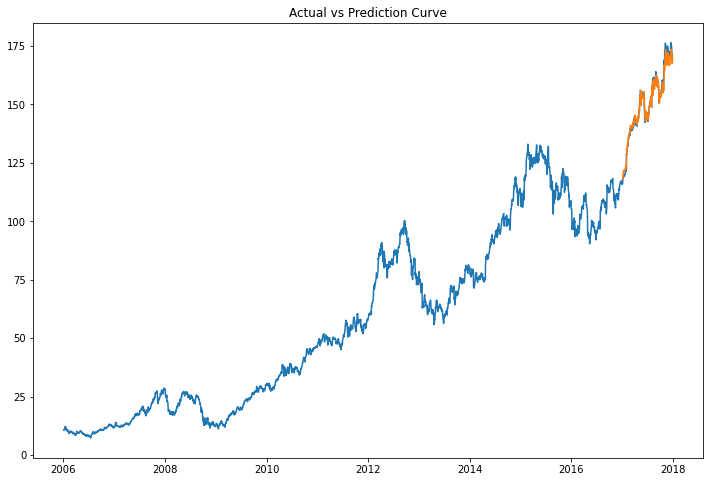

RMSE Loss :  2.064804779383417


In [25]:
execution(df_wrk_1,time_step,loss,optimizer,epochs,batch_size,verbose,columns,val_split)

#### Thoughts
    * RMSE improved from 23.648(Monthly - SARIMA) to 2.06(LSTM) - 91.4% improvement over RMSE.